In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time, json
import pandas as pd
from openai import OpenAI
from tqdm.auto import tqdm
import spacy

import sys
sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-02-19 17:13:51 __main__ INFO     torch.__version__='2.5.0+cu124', torch.version.cuda='12.4'
2025-02-19 17:13:51 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2025-02-19 17:13:51 __main__ INFO     transformers.__version__='4.48.1'


In [3]:
os.listdir(os.path.join(env_utils.DEFAULT_MODELS_DIR, "meta-llama"))

['Llama-3.1-8B',
 'Llama-3.1-8B-Instruct',
 'Llama-2-7b-chat-hf',
 'Llama-3.2-3B-Instruct',
 'Llama-3.2-3B',
 'Llama-3.2-1B']

In [4]:
import torch

from nnsight import LanguageModel
from src.models import ModelandTokenizer

model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-2-27b-it"
# model_key = "Qwen/Qwen2-7B"
# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.float16,
)

2025-02-19 17:13:51 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

2025-02-19 17:13:57 src.models INFO     loaded model </home/local_arnab/Codes/00_MODEL/meta-llama/Llama-3.1-8B> | size: 15316.508 MB | dtype: torch.float16 | device: cuda:0


In [5]:
from src.probing.utils import (
    ProbingPrompt,
    ProbingLatents,
    prepare_probing_input,
    get_lm_generated_answer,
    check_if_answer_is_correct,
)

In [6]:
Instructions = f"""Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None"."""

# Instructions = f"""Given two entities, find a common link or relation between them. If there is no connection just answer "None"."""

block_separator = "\n#"
question_marker = "\nQ: "
answer_marker = "\nA:"

examples = """#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
"""

# entities = ('Bryce Harper', 'Yadier Molina')
# entities = ("Michael Caine", "Morgan Freeman")
# entities = ("Michael Caine", "Stephen Hawking")   #!
# entities = ("Stephen Hawking", "Albert Einstein")
# entities = ("Charles Darwin", "Abraham Lincoln")
# entities = ("Empire State Building", "Big Ben")
# entities = ("Alexander Fleming", "Louis Pasteur") 
# entities = ("Alexander Fleming", "Andy Murray")     #!
# entities = ("Alexander Fleming", "Sean Connery")    #!
# entities = ("Ian McKellen", "Michael Fassbender")    #!
# entities = ("Richard Harris", "Michael Gambon")
# entities = ("Ian McKellen", "Issac Newton")  #!
# entities = ("Issac Newton", "Ian McKellen")

# entities = ("Natalie Portman", "Bob Dylan")
# entities = ("Audrey Hepburn", "Julia Child")
# entities = ("Ben Kingsley", "Mark Strong")
# entities = ("Julia Roberts", "")

# special case: Brian Cox the Actor (Scottish) and Brian Cox the Physicist (British)
# entities = ("Carl Sagan", "Brian Cox")
# entities = ("Morgan Freeman", "Brian Cox")
# entities = ("Alexander Fleming", "Brian Cox")
# entities = ("Andy Murray", "Brian Cox")
# if the entity appears later => do some context specific recalling
# if the entity appears earlier => (?) Hybrid representation of both entities? 
# ---------------------------------------------------------------------------------

# entities = ("Michael Jordan", "Kobe Bryant")

# entities = ("Hugh Jackman", "Ricky Ponting")

# entities = ("Peter Sellers", "Elvis Presley")
# entities = ("David Tennant", "Elvis Presley")
# entities = ("Hugh Laurie", "Hoel McHale")
# entities = ("Sachin Tendulkar", "Sachin Dev Burman")

# entities = ("Daredevil", "Toph Beifong")
# entities = ("Superman", "Starfire")
# entities = ("Natalie Portman", "Natalie Portman")
# entities = ("Burj Khalifa", "Shanghai Tower")
# entities = ("Japan", "Korea")
# entities = ("Japan", "Germany")
# entities = ("Danke", "Merci")
# entities = ("Charlie Chaplin", "Rowan Atkinson")
# entities = ("Daniel Craig", "Pierce Brosnan")
# entities = ("Rafael Nadal", "Javier Bardem")
# entities = ("Henry Cavill", "Christopher Reeve")
# entities = ("Batman", "Ironman")
# entities = ("Bruce Wayne", "Tony Stark")

# ---------------------------------------------------------------------------------
# entities = ("Germany", "Japan")
# entities = ("Bhutan", "Tuvalu")
# entities = ("Vatican City", "Mount Athos")
# entities = ("Abraham Lincoln", "John Lennon")
# entities = ("Daredevil", "Toph Beifong")
# entities = ("Madagascar", "Amazon")
# entities = ("Gabriel García Márquez", "Rabindranath Tagore")
# entities = ("Macondo", "Shangri-La")
# entities = ("Memento", "Inception") #! Verify with causal tracing 
# entities = ("Rosetta Stone", "Dead Sea Scrolls") #! Verify with causal tracing

# Actors who played the same character
#! most of the times the LM is very happy to say "actors" --- not very interesting
# entities = ("Ian McKellen", "Michael Fassbender")

# entities = ("Batman", "Joker")
# entities = ("Superman", "Lex Luthor")
entities = ("Leonardo da Vinci", "Benjamin Franklin")
# entities = ("Mark Twain", "Winston Churchill")
# entities = ("Julius Caesar", "Nepoleon Bonaparte")
# entities = ("Julius Caesar", "Julius Caesar")
# entities = ("Beethoven", "Goya")
# entities = ("The Godfather", "Goodfellas")
# entities = ("The Green Mile", "The Shawshank Redemption")
# entities = ("Christopher Columbus", "Vasco da Gama")

prefix = f"""{Instructions}
{examples}
"""

prompt = prepare_probing_input(
    mt=mt,
    entities=entities,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both"
    # answer_prefix = " They are both used to say"
)

print(mt.tokenizer.decode(prompt.tokenized["input_ids"][0]))

answer = get_lm_generated_answer(
    mt=mt, prompt=prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f"{answer=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None".
#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: Leonardo da Vinci and Benjamin Franklin
A: They are/were both


From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


answer='polymaths.'


In [7]:
# common_entity = "Alexander Fleming"
# clean_entity = "Louis Pasteur"
# patch_entity = "Andy Murray" 

# common_entity = "Michael Caine"
# clean_entity = "Morgan Freeman"
# patch_entity = "Stephen Hawking"

# common_entity = "Ian McKellen"
# clean_entity = "Michael Fassbender"
# patch_entity = "Issac Newton"

# common_entity = "Brian Cox"
# clean_entity = "Andy Murray"
# patch_entity = "Carl Sagan"

# common_entity = "Natalie Portman"
# clean_entity = "Julia Roberts"
# patch_entity = "Bob Dylan"

# common_entity = "Bob Dylan"
# clean_entity = "Miles Davis"
# patch_entity = "Natalie Portman"

common_entity = "python"
clean_entity = "java"
patch_entity = "cobra"

# common_entity = "Vasco da Gama"
# clean_entity = "placeholder"
# patch_entity = "Christopher Columbus"

clean_prompt = prepare_probing_input(
    mt=mt,
    entities=(clean_entity, common_entity),
    # entities=(common_entity, clean_entity),
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    answer_prefix=" They are/were both",
    return_offsets_mapping=True
)
clean_answer = get_lm_generated_answer(
    mt=mt, prompt=clean_prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
)
print(f"{clean_answer=}")

patched_prompt = prepare_probing_input(
    mt=mt,
    entities=(patch_entity, common_entity),
    # entities=(common_entity, patch_entity),
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    answer_prefix=" They are/were both",
    return_offsets_mapping=True
)
patched_answer = get_lm_generated_answer(
    mt=mt, prompt=patched_prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f"{patched_answer=}")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


clean_answer='programming languages.'
patched_answer='venomous snakes.'


In [ ]:
from src.utils.typing import TokenizerOutput, PredictedToken
from src.tokens import align_patching_positions
from src.functional import PatchSpec, get_hs, logit_lens, predict_next_token
from typing import Optional, Literal

def do_path_ablation(
    mt: ModelandTokenizer,
    input: TokenizerOutput,
    restore_states: list[PatchSpec],
    block_locations: list[tuple[str, int]],
    ans_token: int
) -> PredictedToken:
    corrupted_states = get_hs(
        mt=mt, input=input, locations=block_locations, return_dict=True
    )
    # restore the clean states from `restore_states`
    # patch the corrupted states back to block those locations
    patch_spec = restore_states + [
        PatchSpec(
            location=loc,
            patch=corrupted_states[loc]
        )
        for loc in block_locations
    ]
    last_h = get_hs(
        mt=mt, 
        input=input,
        locations=(mt.layer_name_format.format(mt.n_layer-1), -1),
        patches=patch_spec,
        return_dict=False
    )

    ablated_pred, track_ans=logit_lens(mt=mt, h=last_h, interested_tokens=[ans_token])
    rank, track_ans = list(track_ans.values())[0]

    return track_ans

#TODO: decouple the alignment and token_idx selection? (maybe later)
def trace_path_ablation_effects(
    mt: ModelandTokenizer,
    prompt_template: str,
    clean_subj: str,
    patched_subj: str,
    clean_input: Optional[TokenizerOutput] = None,
    patched_input: Optional[TokenizerOutput] = None,
    at_token: Literal["last", "subj_last"] | None = "last",
    token_idx: Optional[int] = None
):
    aligned = align_patching_positions(
        mt=mt,
        prompt_template=prompt_template,
        clean_subj=clean_subj,
        patched_subj=patched_subj,
        clean_input=clean_input,
        patched_input=patched_input,
        trace_start_marker=None,
    )
    clean_inputs = aligned["clean_input"]
    patch_inputs = aligned["patched_input"]
    subj_range = aligned["subj_range"]

    patch_ans = predict_next_token(mt=mt, inputs=patch_inputs, k=1)[0][0]
    logger.debug(f"{patch_ans=}")

    clean_ans, corrupt_rank = predict_next_token(
        mt=mt, inputs=clean_inputs,
        token_of_interest=[patch_ans.token_id],
    )
    clean_ans = clean_ans[0][0]
    corrupt_rank, base_ans = list(corrupt_rank[0].values())[0]
    logger.debug(f"{clean_ans=}")
    logger.debug(f"{corrupt_rank=} | {base_ans=}")

    assert clean_inputs["input_ids"].shape[1] == patch_inputs["input_ids"].shape[1]

    if token_idx is None:
        if at_token == "last":
            token_idx = clean_inputs["input_ids"].shape[1] - 1
        elif at_token == "subj_last":
            token_idx = subj_range[1] - 1
        else:
            raise ValueError(f"Invalid {at_token=}")
    else:
        if at_token is not None:
            logger.warning(f"Ignoring {at_token=} since {token_idx=} is provided")
        
        

    mlp_ablation_locations = [
        (mt.mlp_module_name_format.format(i), token_idx)
        for i in range(mt.n_layer)
    ]
    attn_ablation_locations = [
        (mt.attn_module_name_format.format(i), token_idx)
        for i in range(mt.n_layer)
    ]
    residual_locations = [
        (mt.layer_name_format.format(i), token_idx)
        for i in range(mt.n_layer)
    ]

    path_blocking_effects = {}

    restore_states = get_hs(
        mt=mt, input=patch_inputs, locations=residual_locations, return_dict=True
    )
    logger.debug("="*50)
    for i in tqdm(range(mt.n_layer)):
        restore_location = (mt.layer_name_format.format(i), token_idx)
        # logger.debug(restore_location)
        cur_restore = [
            PatchSpec(
                location=restore_location,
                patch=restore_states[restore_location]
            )
        ]
        h_restore_pred = do_path_ablation(
            mt=mt, input=clean_inputs,
            restore_states=cur_restore,
            block_locations=[],         # don't block anything
            ans_token=patch_ans.token_id
        )
        # logger.debug(f"{h_restore_pred=}")

        mlp_ablation_pred = do_path_ablation(
            mt=mt, input=clean_inputs,
            restore_states=cur_restore,
            block_locations=mlp_ablation_locations, # block the MLP contributions   
            ans_token=patch_ans.token_id
        )
        # logger.debug(f"{mlp_ablation_pred=}")

        attn_ablation_pred = do_path_ablation(
            mt=mt, input=clean_inputs,
            restore_states=cur_restore,
            block_locations=attn_ablation_locations,   # block the attention contributions
            ans_token=patch_ans.token_id
        )
        # logger.debug(f"{attn_ablation_pred=}")

        path_blocking_effects[i] = {
            "h_restored": h_restore_pred,
            "mlp_blocked": mlp_ablation_pred,
            "attn_blocked": attn_ablation_pred
        }
        # logger.debug("-"*50)
    
    return dict(
        clean_inputs=clean_inputs,
        patch_inputs=patch_inputs,
        patch_ans=patch_ans,
        base_ans=base_ans,
        patch_blocking_effects=path_blocking_effects
    )    

In [9]:
prompt_template = clean_prompt.prompt.replace(clean_entity, "{}")
print(prompt_template)

Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None".
#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: {} and python
A: They are/were both


In [10]:
# prompt_template = "{} is located in the city of"
# clean_entity = "Eiffel Tower"
# patch_entity = "The Space Needle"

# path_blocking_effects = trace_path_ablation_effects(
#     mt=mt,
#     prompt_template=prompt_template,
#     clean_subj=clean_entity,
#     patched_subj=patch_entity,
#     at_token="last"
# )

In [11]:
with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
    coincidences = json.load(f)

logger.info(f"{len(coincidences['examples'])=}")

2025-02-19 17:14:02 __main__ INFO     len(coincidences['examples'])=20


In [18]:
path_blocking_effects = []
at_token = "last"

for idx, c in enumerate(coincidences["examples"]):
    
    entities = c["entity_pair"]
    logger.info(f"({idx+1}/{len(coincidences['examples'])})  {entities=}")

    common_entity = entities[1]
    patch_entity = entities[0]
    clean_entity = "placeholder"

    clean_prompt = prepare_probing_input(
        mt=mt,
        entities=(clean_entity, common_entity),
        prefix=prefix,
        answer_marker=answer_marker,
        question_marker=question_marker,
        block_separator=block_separator,
        is_a_reasoning_model="deepseek" in model_key.lower(),
        answer_prefix=" They are/were both",
        return_offsets_mapping=True
    )
    clean_answer = get_lm_generated_answer(
        mt=mt, prompt=clean_prompt, 
        is_a_reasoning_model="deepseek" in model_key.lower()
    )
    logger.info(f"({clean_entity}, {common_entity}) => {clean_answer}")

    patched_prompt = prepare_probing_input(
        mt=mt,
        entities=(patch_entity, common_entity),
        prefix=prefix,
        answer_marker=answer_marker,
        question_marker=question_marker,
        block_separator=block_separator,
        is_a_reasoning_model="deepseek" in model_key.lower(),
        answer_prefix=" They are/were both",
        return_offsets_mapping=True
    )

    prompt_template = clean_prompt.prompt.replace(clean_entity, "{}")
    
    cur_effects = trace_path_ablation_effects(
        mt=mt,
        prompt_template=prompt_template,
        clean_subj=clean_entity,
        patched_subj=patch_entity,
        at_token=at_token
    )

    path_blocking_effects.append(cur_effects)

2025-02-19 17:28:55 __main__ INFO     (1/20)  entities=['Germany', 'Japan']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:28:56 __main__ INFO     (placeholder, Japan) => countries.
2025-02-19 17:28:57 __main__ DEBUG    patch_ans=PredictedToken(token=' Axis', prob=0.2440185546875, logit=16.1875, token_id=35574)
2025-02-19 17:28:57 __main__ DEBUG    clean_ans=PredictedToken(token=' countries', prob=0.11688232421875, logit=13.296875, token_id=5961)
2025-02-19 17:28:57 __main__ DEBUG    corrupt_rank=3076 | base_ans=PredictedToken(token=' Axis', prob=1.4424324035644531e-05, logit=4.296875, token_id=35574)
2025-02-19 17:28:57 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]

2025-02-19 17:29:38 __main__ INFO     (2/20)  entities=['Hugh Jackman', 'Ryan Reynolds']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:29:40 __main__ INFO     (placeholder, Ryan Reynolds) => actors.
2025-02-19 17:29:40 __main__ DEBUG    patch_ans=PredictedToken(token=' X', prob=0.15087890625, logit=15.5859375, token_id=1630)
2025-02-19 17:29:40 __main__ DEBUG    clean_ans=PredictedToken(token=' actors', prob=0.2154541015625, logit=15.0703125, token_id=20142)
2025-02-19 17:29:40 __main__ DEBUG    corrupt_rank=21 | base_ans=PredictedToken(token=' X', prob=0.006816864013671875, logit=11.6171875, token_id=1630)
2025-02-19 17:29:40 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:43<00:00,  1.35s/it]

2025-02-19 17:30:23 __main__ INFO     (3/20)  entities=['Bhutan', 'Tuvalu']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:30:25 __main__ INFO     (placeholder, Tuvalu) => countries.
2025-02-19 17:30:25 __main__ DEBUG    patch_ans=PredictedToken(token=' monarch', prob=0.1822509765625, logit=16.046875, token_id=63854)
2025-02-19 17:30:25 __main__ DEBUG    clean_ans=PredictedToken(token=' countries', prob=0.1409912109375, logit=14.703125, token_id=5961)
2025-02-19 17:30:25 __main__ DEBUG    corrupt_rank=43 | base_ans=PredictedToken(token=' monarch', prob=0.0032634735107421875, logit=10.9375, token_id=63854)
2025-02-19 17:30:25 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]

2025-02-19 17:31:07 __main__ INFO     (4/20)  entities=['Vatican City', 'Mount Athos']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:31:09 __main__ INFO     (placeholder, Mount Athos) => monasteries.
2025-02-19 17:31:09 __main__ DEBUG    patch_ans=PredictedToken(token=' independent', prob=0.121826171875, logit=15.4296875, token_id=9678)
2025-02-19 17:31:09 __main__ DEBUG    clean_ans=PredictedToken(token=' mon', prob=0.1280517578125, logit=14.53125, token_id=1647)
2025-02-19 17:31:09 __main__ DEBUG    corrupt_rank=20 | base_ans=PredictedToken(token=' independent', prob=0.00844573974609375, logit=11.8125, token_id=9678)
2025-02-19 17:31:09 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:42<00:00,  1.33s/it]

2025-02-19 17:31:52 __main__ INFO     (5/20)  entities=['Rosetta Stone', 'Dead Sea Scrolls']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:31:53 __main__ INFO     (placeholder, Dead Sea Scrolls) => artifacts.
2025-02-19 17:31:54 __main__ DEBUG    patch_ans=PredictedToken(token=' ancient', prob=0.3876953125, logit=17.703125, token_id=14154)
2025-02-19 17:31:54 __main__ DEBUG    clean_ans=PredictedToken(token=' religious', prob=0.091796875, logit=15.1171875, token_id=10597)
2025-02-19 17:31:54 __main__ DEBUG    corrupt_rank=2 | base_ans=PredictedToken(token=' ancient', prob=0.087646484375, logit=15.0703125, token_id=14154)
2025-02-19 17:31:54 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]

2025-02-19 17:32:36 __main__ INFO     (6/20)  entities=['Leonardo da Vinci', 'Benjamin Franklin']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:32:37 __main__ INFO     (placeholder, Benjamin Franklin) => American citizens.
2025-02-19 17:32:37 __main__ DEBUG    patch_ans=PredictedToken(token=' polym', prob=0.29150390625, logit=17.171875, token_id=46033)
2025-02-19 17:32:38 __main__ DEBUG    clean_ans=PredictedToken(token=' American', prob=0.127685546875, logit=15.3203125, token_id=3778)
2025-02-19 17:32:38 __main__ DEBUG    corrupt_rank=18 | base_ans=PredictedToken(token=' polym', prob=0.0122528076171875, logit=12.9765625, token_id=46033)
2025-02-19 17:32:38 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]

2025-02-19 17:33:19 __main__ INFO     (7/20)  entities=['Daredevil', 'Toph Beifong']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:33:21 __main__ INFO     (placeholder, Toph Beifong) => characters in Avatar: The Last Airbender.
2025-02-19 17:33:21 __main__ DEBUG    patch_ans=PredictedToken(token=' blind', prob=0.7431640625, logit=18.484375, token_id=18507)
2025-02-19 17:33:21 __main__ DEBUG    clean_ans=PredictedToken(token=' characters', prob=0.201416015625, logit=14.75, token_id=5885)
2025-02-19 17:33:21 __main__ DEBUG    corrupt_rank=4 | base_ans=PredictedToken(token=' blind', prob=0.0550537109375, logit=13.453125, token_id=18507)
2025-02-19 17:33:21 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:42<00:00,  1.31s/it]

2025-02-19 17:34:03 __main__ INFO     (8/20)  entities=['Memento', 'Inception']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:34:05 __main__ INFO     (placeholder, Inception) => movies.
2025-02-19 17:34:05 __main__ DEBUG    patch_ans=PredictedToken(token=' directed', prob=0.724609375, logit=18.453125, token_id=15910)
2025-02-19 17:34:05 __main__ DEBUG    clean_ans=PredictedToken(token=' movies', prob=0.2861328125, logit=15.4765625, token_id=9698)
2025-02-19 17:34:05 __main__ DEBUG    corrupt_rank=2 | base_ans=PredictedToken(token=' directed', prob=0.1722412109375, logit=14.96875, token_id=15910)
2025-02-19 17:34:05 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]

2025-02-19 17:34:47 __main__ INFO     (9/20)  entities=['Julius Caesar', 'Nepoleon Bonaparte']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:34:48 __main__ INFO     (placeholder, Nepoleon Bonaparte) => French.
2025-02-19 17:34:49 __main__ DEBUG    patch_ans=PredictedToken(token=' military', prob=0.241455078125, logit=17.53125, token_id=6411)
2025-02-19 17:34:49 __main__ DEBUG    clean_ans=PredictedToken(token=' French', prob=0.15185546875, logit=15.375, token_id=8753)
2025-02-19 17:34:49 __main__ DEBUG    corrupt_rank=2 | base_ans=PredictedToken(token=' military', prob=0.08319091796875, logit=14.7734375, token_id=6411)
2025-02-19 17:34:49 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:42<00:00,  1.31s/it]

2025-02-19 17:35:31 __main__ INFO     (10/20)  entities=['The Godfather', 'Goodfellas']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:35:33 __main__ INFO     (placeholder, Goodfellas) => movies.
2025-02-19 17:35:33 __main__ DEBUG    patch_ans=PredictedToken(token=' mob', prob=0.1612548828125, logit=16.96875, token_id=12881)
2025-02-19 17:35:33 __main__ DEBUG    clean_ans=PredictedToken(token=' movies', prob=0.23779296875, logit=15.09375, token_id=9698)
2025-02-19 17:35:33 __main__ DEBUG    corrupt_rank=6 | base_ans=PredictedToken(token=' mob', prob=0.0228118896484375, logit=12.75, token_id=12881)
2025-02-19 17:35:33 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]

2025-02-19 17:36:14 __main__ INFO     (11/20)  entities=['The Green Mile', 'The Shawshank Redemption']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:36:16 __main__ INFO     (placeholder, The Shawshank Redemption) => movies.
2025-02-19 17:36:16 __main__ DEBUG    patch_ans=PredictedToken(token=' directed', prob=0.1981201171875, logit=15.9140625, token_id=15910)
2025-02-19 17:36:16 __main__ DEBUG    clean_ans=PredictedToken(token=' movies', prob=0.109619140625, logit=14.015625, token_id=9698)
2025-02-19 17:36:16 __main__ DEBUG    corrupt_rank=2 | base_ans=PredictedToken(token=' directed', prob=0.0736083984375, logit=13.6171875, token_id=15910)
2025-02-19 17:36:16 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]

2025-02-19 17:36:58 __main__ INFO     (12/20)  entities=['Christopher Columbus', 'Vasco da Gama']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:36:59 __main__ INFO     (placeholder, Vasco da Gama) => Portuguese.
2025-02-19 17:37:00 __main__ DEBUG    patch_ans=PredictedToken(token=' explor', prob=0.45458984375, logit=18.71875, token_id=48539)
2025-02-19 17:37:00 __main__ DEBUG    clean_ans=PredictedToken(token=' Portuguese', prob=0.23095703125, logit=16.015625, token_id=43288)
2025-02-19 17:37:00 __main__ DEBUG    corrupt_rank=2 | base_ans=PredictedToken(token=' explor', prob=0.11431884765625, logit=15.3125, token_id=48539)
2025-02-19 17:37:00 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]

2025-02-19 17:37:42 __main__ INFO     (13/20)  entities=['Elephant', 'Whale']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:37:43 __main__ INFO     (placeholder, Whale) => animals.
2025-02-19 17:37:43 __main__ DEBUG    patch_ans=PredictedToken(token=' mammals', prob=0.310302734375, logit=16.71875, token_id=56669)
2025-02-19 17:37:44 __main__ DEBUG    clean_ans=PredictedToken(token=' animals', prob=0.0491943359375, logit=12.1875, token_id=10099)
2025-02-19 17:37:44 __main__ DEBUG    corrupt_rank=4 | base_ans=PredictedToken(token=' mammals', prob=0.0280303955078125, logit=11.625, token_id=56669)
2025-02-19 17:37:44 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]

2025-02-19 17:38:25 __main__ INFO     (14/20)  entities=['Emu', 'Ostrich']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:38:27 __main__ INFO     (placeholder, Ostrich) => animals.
2025-02-19 17:38:27 __main__ DEBUG    patch_ans=PredictedToken(token=' flight', prob=0.406982421875, logit=17.03125, token_id=11213)
2025-02-19 17:38:27 __main__ DEBUG    clean_ans=PredictedToken(token=' animals', prob=0.12213134765625, logit=13.4765625, token_id=10099)
2025-02-19 17:38:27 __main__ DEBUG    corrupt_rank=293 | base_ans=PredictedToken(token=' flight', prob=0.00034046173095703125, logit=7.59375, token_id=11213)
2025-02-19 17:38:27 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:41<00:00,  1.28s/it]

2025-02-19 17:39:08 __main__ INFO     (15/20)  entities=['Brazil', 'Turkey']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:39:10 __main__ INFO     (placeholder, Turkey) => countries.
2025-02-19 17:39:10 __main__ DEBUG    patch_ans=PredictedToken(token=' members', prob=0.22412109375, logit=15.78125, token_id=3697)
2025-02-19 17:39:10 __main__ DEBUG    clean_ans=PredictedToken(token=' countries', prob=0.1246337890625, logit=13.796875, token_id=5961)
2025-02-19 17:39:10 __main__ DEBUG    corrupt_rank=6 | base_ans=PredictedToken(token=' members', prob=0.033538818359375, logit=12.484375, token_id=3697)
2025-02-19 17:39:10 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]

2025-02-19 17:39:52 __main__ INFO     (16/20)  entities=['jellyfish', 'lobster']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:39:53 __main__ INFO     (placeholder, lobster) => used as a placeholder in a text.
2025-02-19 17:39:54 __main__ DEBUG    patch_ans=PredictedToken(token=' in', prob=0.201904296875, logit=15.6484375, token_id=304)
2025-02-19 17:39:54 __main__ DEBUG    clean_ans=PredictedToken(token=' in', prob=0.030181884765625, logit=11.65625, token_id=304)
2025-02-19 17:39:54 __main__ DEBUG    corrupt_rank=1 | base_ans=PredictedToken(token=' in', prob=0.030181884765625, logit=11.65625, token_id=304)
2025-02-19 17:39:54 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:39<00:00,  1.25s/it]

2025-02-19 17:40:34 __main__ INFO     (17/20)  entities=['corn', 'wheat']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:40:35 __main__ INFO     (placeholder, wheat) => used as a placeholder in the English language.
2025-02-19 17:40:36 __main__ DEBUG    patch_ans=PredictedToken(token=' staple', prob=0.1856689453125, logit=17.078125, token_id=50056)
2025-02-19 17:40:36 __main__ DEBUG    clean_ans=PredictedToken(token=' used', prob=0.09661865234375, logit=13.1875, token_id=1511)
2025-02-19 17:40:36 __main__ DEBUG    corrupt_rank=19 | base_ans=PredictedToken(token=' staple', prob=0.00913238525390625, logit=10.828125, token_id=50056)
2025-02-19 17:40:36 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:40<00:00,  1.26s/it]

2025-02-19 17:41:16 __main__ INFO     (18/20)  entities=['crocodile', 'shark']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:41:18 __main__ INFO     (placeholder, shark) => fictional characters.
2025-02-19 17:41:18 __main__ DEBUG    patch_ans=PredictedToken(token=' apex', prob=0.1292724609375, logit=15.6875, token_id=72627)
2025-02-19 17:41:18 __main__ DEBUG    clean_ans=PredictedToken(token=' fictional', prob=0.07073974609375, logit=12.6796875, token_id=44682)
2025-02-19 17:41:18 __main__ DEBUG    corrupt_rank=158 | base_ans=PredictedToken(token=' apex', prob=0.0007619857788085938, logit=8.1484375, token_id=72627)
2025-02-19 17:41:18 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:40<00:00,  1.27s/it]

2025-02-19 17:41:59 __main__ INFO     (19/20)  entities=['crab', 'spider']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:42:00 __main__ INFO     (placeholder, spider) => characters in the Marvel Cinematic Universe.
2025-02-19 17:42:01 __main__ DEBUG    patch_ans=PredictedToken(token=' ar', prob=0.4072265625, logit=16.71875, token_id=802)
2025-02-19 17:42:01 __main__ DEBUG    clean_ans=PredictedToken(token=' characters', prob=0.045318603515625, logit=12.1484375, token_id=5885)
2025-02-19 17:42:01 __main__ DEBUG    corrupt_rank=101 | base_ans=PredictedToken(token=' ar', prob=0.0012454986572265625, logit=8.5546875, token_id=802)
2025-02-19 17:42:01 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]

2025-02-19 17:42:42 __main__ INFO     (20/20)  entities=['copper', 'gold']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 17:42:44 __main__ INFO     (placeholder, gold) => used as a placeholder in the past.
2025-02-19 17:42:44 __main__ DEBUG    patch_ans=PredictedToken(token=' used', prob=0.4423828125, logit=18.171875, token_id=1511)
2025-02-19 17:42:44 __main__ DEBUG    clean_ans=PredictedToken(token=' used', prob=0.064453125, logit=12.1015625, token_id=1511)
2025-02-19 17:42:44 __main__ DEBUG    corrupt_rank=1 | base_ans=PredictedToken(token=' used', prob=0.064453125, logit=12.1015625, token_id=1511)
2025-02-19 17:42:44 __main__ DEBUG    ==================================================


100%|██████████| 32/32 [00:42<00:00,  1.31s/it]


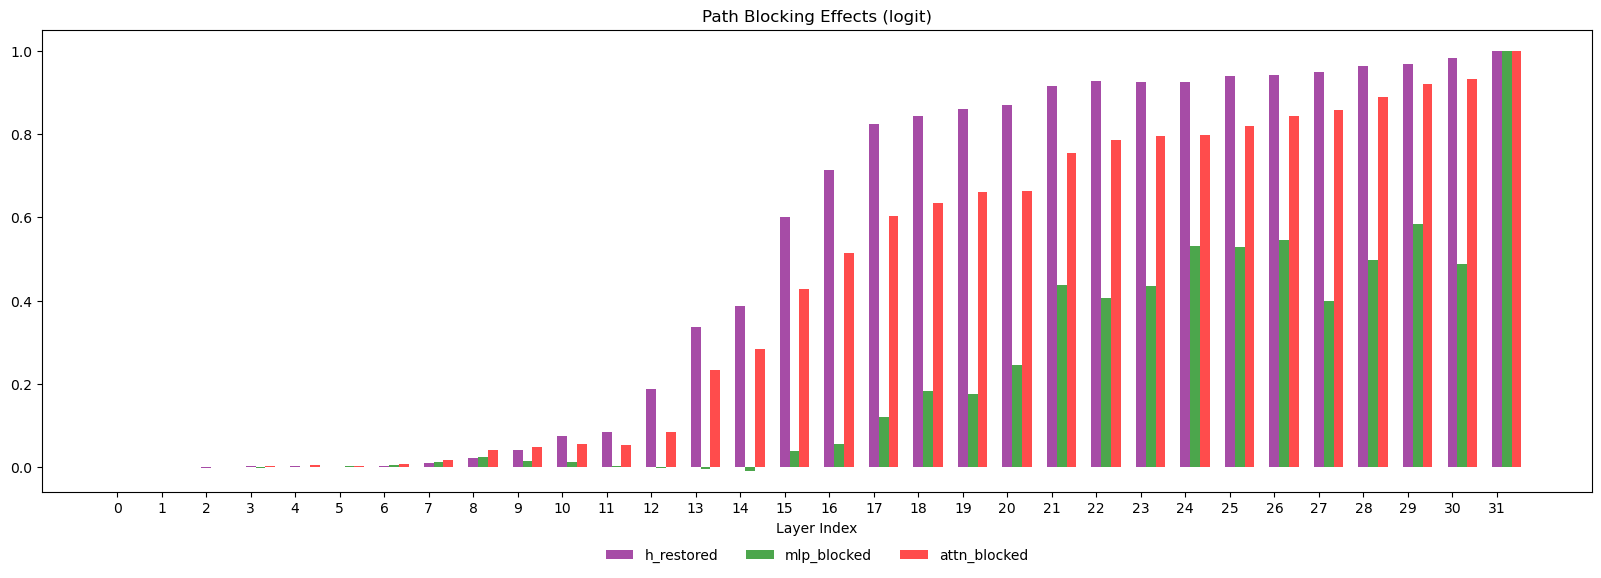

In [29]:
import numpy as np

def process_path_blocking_results(
    path_blocking_effects: list[dict],
    metric: str = "prob"
):
    h_restored = {l: [] for l in range(mt.n_layer)}
    mlp_blocked = {l: [] for l in range(mt.n_layer)}
    attn_blocked = {l: [] for l in range(mt.n_layer)}
    for effect in path_blocking_effects:
        high_bar = getattr(effect["patch_ans"], metric) 
        low_bar = getattr(effect["base_ans"], metric)
        denominator = high_bar - low_bar
        for l in range(mt.n_layer):
            h_restored[l] = (getattr(effect["patch_blocking_effects"][l]["h_restored"], metric) - low_bar) / denominator
            mlp_blocked[l] = (getattr(effect["patch_blocking_effects"][l]["mlp_blocked"], metric) - low_bar) / denominator
            attn_blocked[l] = (getattr(effect["patch_blocking_effects"][l]["attn_blocked"], metric) - low_bar) / denominator
    
    return {
        l : {
            "h_restored": np.mean(h_restored[l]),
            "mlp_blocked": np.mean(mlp_blocked[l]),
            "attn_blocked": np.mean(attn_blocked[l])
        } for l in range(mt.n_layer)
    }

metric="logit"
plot_results = process_path_blocking_results(path_blocking_effects, metric)
# plot_results = process_path_blocking_results([path_blocking_effects[5]], metric)

from matplotlib import pyplot as plt

plt.figure(figsize=(20, 6))
bar_width = 0.22

plt.title(f"Path Blocking Effects ({metric})")
keys = list(range(mt.n_layer))
color_map = {
    "h_restored": "purple",
    "mlp_blocked": "green",
    "attn_blocked": "red"
}

for idx, kind in enumerate(["h_restored", "mlp_blocked", "attn_blocked"]):
    plt.bar(
        [k + idx*bar_width for k in keys],
        height=[plot_results[k][kind] for k in keys],
        width=bar_width,
        label=kind,
        alpha=0.7,
        color=color_map[kind]
    )

plt.legend(ncol = 4, bbox_to_anchor=(0.5, -.18), loc='lower center', frameon=False)
plt.xticks(keys)
plt.xlabel("Layer Index")
plt.show()
